In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [3]:
dfb4 = pd.read_csv('Data/Building Data/Building 4.csv')

In [4]:
dfb4

,Unnamed: 0,series_value,datetime,Year,Month,Day_of_Month,Hour,minutes,series_name
0,5,2.0,2019-07-03 06:00:00,2019,7,3,6,0,Building4
1,9,1.0,2019-07-03 07:00:00,2019,7,3,7,0,Building4
2,13,1.0,2019-07-03 08:00:00,2019,7,3,8,0,Building4
3,17,1.0,2019-07-03 09:00:00,2019,7,3,9,0,Building4
4,21,2.0,2019-07-03 10:00:00,2019,7,3,10,0,Building4
...,...,...,...,...,...,...,...,...,...
6987,46705,1.0,2020-10-31 17:00:00,2020,10,31,17,0,Building4
6988,46709,2.0,2020-10-31 18:00:00,2020,10,31,18,0,Building4
6989,46713,1.0,2020-10-31 19:00:00,2020,10,31,19,0,Building4
6990,46717,1.0,2020-10-31 20:00:00,2020,10,31,20,0,Building4


In [7]:
data = dfb4['series_value'][5000:6000]

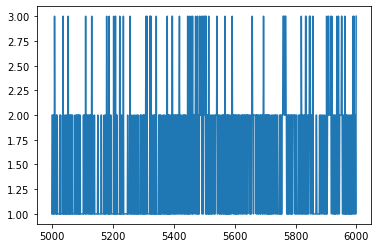

In [8]:
plt.plot(data)

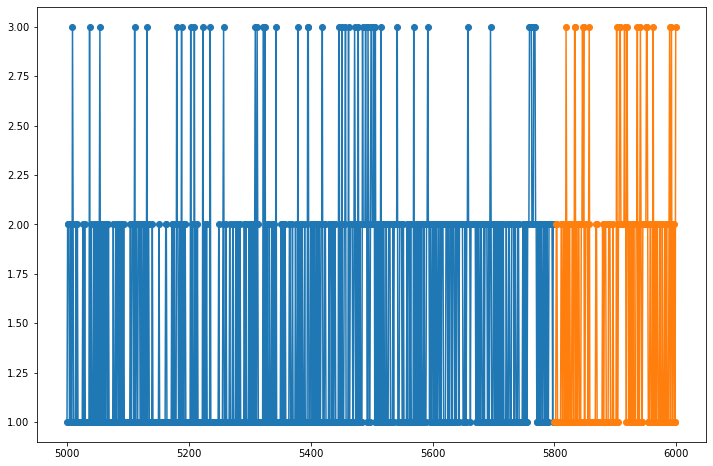

In [9]:
train_size = 0.8

ts = data

split_idx = round(len(data)* train_size)

# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)

In [10]:
modelactual = auto_arima(train, start_p=0, start_q=0, seasonal=True)
modelactual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -724.181
Date:                Tue, 27 Sep 2022   AIC                           1452.361
Time:                        23:14:29   BIC                           1461.728
Sample:                             0   HQIC                          1455.960
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9777      0.007   -137.116      0.000      -0.992      -0.964
sigma2         0.3573      0.017     20.900      0.000       0.324       0.391
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               114.46
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.92
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
data = train
# define model
my_order = (0, 1, 1)
my_seasonal_order = (0, 1, 1, 24)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(end=len(test))

In [13]:
yhat

5000    0.000000
5001    1.000000
5002    1.999999
5003    2.000000
5004    2.000000
          ...   
5196    1.274863
5197    1.391699
5198    1.505149
5199    1.115359
5200    1.612004
Name: predicted_mean, Length: 201, dtype: float64

In [14]:
lst = []
for i in range(5001, 5201):
    lst.append(yhat[i])

In [15]:
forecastdf = pd.DataFrame(lst, columns=['forecast']) 

In [16]:
test

5800    1.0
5801    1.0
5802    1.0
5803    2.0
5804    2.0
       ... 
5995    2.0
5996    2.0
5997    1.0
5998    1.0
5999    3.0
Name: series_value, Length: 200, dtype: float64

In [20]:
lst = []
for i in range(5800, 6000):
    lst.append(test[i])

In [21]:
testdfnew = pd.DataFrame(lst, columns=['test']) 

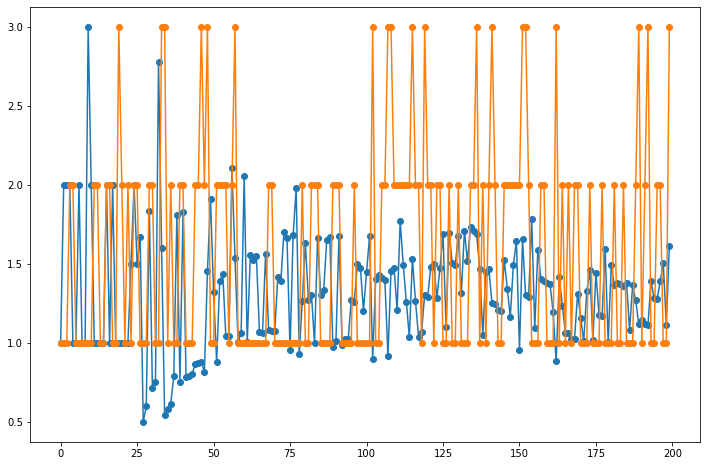

In [23]:
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(forecastdf['forecast'], label='Forecast', **kws)
plt.plot(testdfnew['test'], label='Test', **kws)

In [24]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


pred = forecastdf['forecast'] 
tst = testdfnew['test']
trn = train

mean_absolute_scaled_error(pred,tst,trn)

1.1232245499251687